## Some Exploratory Data Analysis


In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

DATA_DIR = "data"

edu_train_data = "module_Education_train_set.csv"
edu_test_data = "module_Education_test_set.csv"
house_train_data = "module_HouseholdInfo_train_set.csv"
house_test_data = "module_HouseholdInfo_test_set.csv"
pov_train_data = "module_SubjectivePoverty_train_set.csv"

edu_train = pd.read_csv(os.path.join(DATA_DIR, edu_train_data))
edu_test = pd.read_csv(os.path.join(DATA_DIR, edu_test_data))
house_train = pd.read_csv(os.path.join(DATA_DIR, house_train_data))
house_test = pd.read_csv(os.path.join(DATA_DIR, house_test_data))
pov_train = pd.read_csv(os.path.join(DATA_DIR, pov_train_data))

### Let's start with Subjective Poverty first


(5337, 11)


/var/folders/92/lv5lwsyj6pq0h_8d0gm14m680000gn/T/ipykernel_42240/2405359640.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(range(10)))


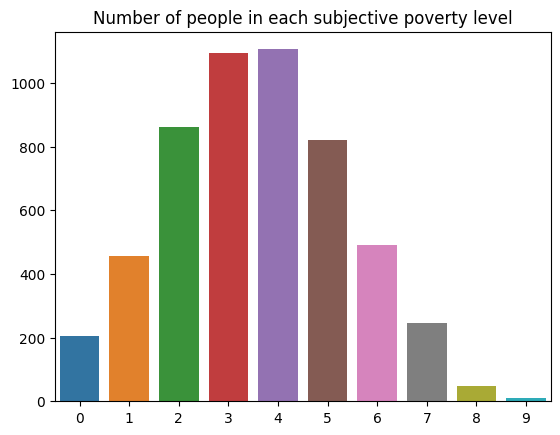

In [2]:
print(pov_train.shape)

# a very normal like distribution!
ax = sns.barplot(pov_train.iloc[:, 1:], estimator="sum", errorbar=None)
ax.set_xticklabels(list(range(10)))
plt.title("Number of people in each subjective poverty level")
plt.show()

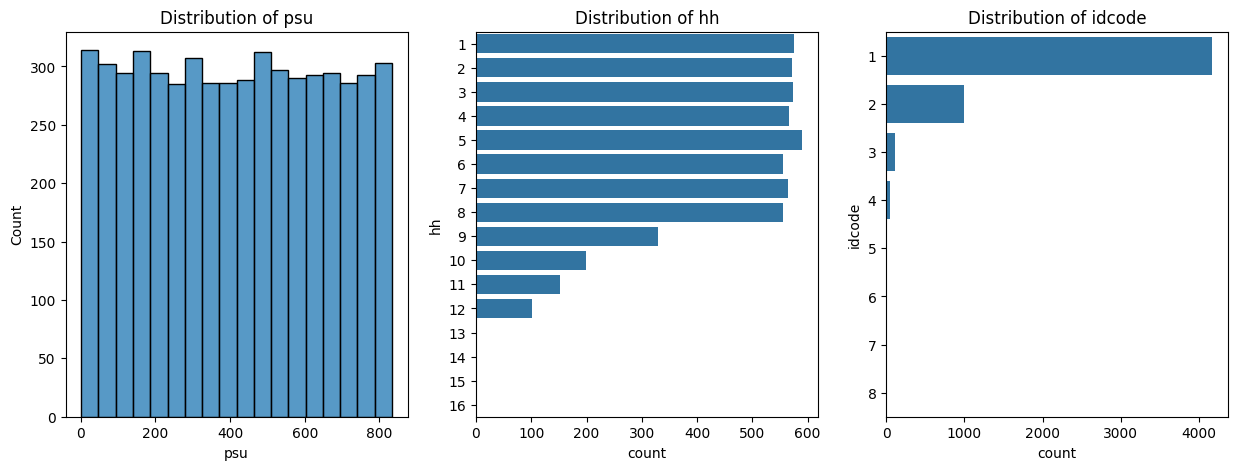

In [3]:
pov_train[["psu", "hh", "idcode"]] = (
    pov_train["psu_hh_idcode"].str.split("_", expand=True).astype(int)
)
# plot the distribution of psu, hh, and idcode
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(pov_train["psu"], ax=ax[0])
ax[0].set_title("Distribution of psu")
sns.countplot(pov_train["hh"].astype(str), ax=ax[1], order=list(range(1, 17)))
ax[1].set_title("Distribution of hh")
sns.countplot(pov_train["idcode"].astype(str), ax=ax[2], order=list(range(1, 9)))
ax[2].set_title("Distribution of idcode")
plt.show()

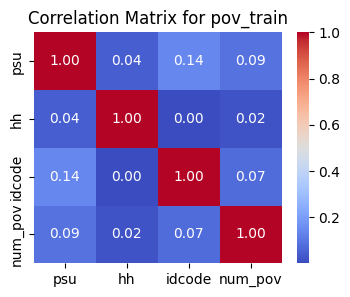

In [4]:
# we might as well convert it to a range of 1-10
# I also tried with just the classes themselves, but not much difference in the correlation matrix
pov_train["num_pov"] = (
    pov_train.iloc[:, 1:11].idxmax(axis=1).str.split("_").str[-1].astype(int)
)
# Calculate the correlation matrix
corr = pov_train[["psu", "hh", "idcode", "num_pov"]].corr()

# Generate a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for pov_train")
plt.show()

### Then Education data


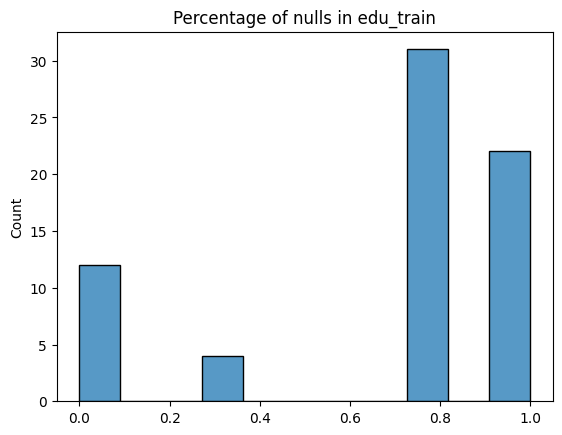

In [5]:
# there are a lot of nulls in the data
# we might as well just take the columns that have less than 50% nulls
# since we also have too many features to work with
sns.histplot(edu_train.isnull().sum(axis=0) / edu_train.shape[0])
plt.title("Percentage of nulls in edu_train")
plt.show()

In [9]:
edu_train[valid_columns].describe()

,q01,q02,q03,q04,q05,q06,q07,Q08,Q14
count,22406.000000,22406.000000,22406.000000,21513.000000,21513.000000,21513.000000,21513.000000,21513.000000,21513.000000
mean,1.132018,1.144024,1.039855,2.107842,5.202808,2.777251,0.808116,1.741319,1.738530
std,0.400707,0.425175,0.195624,1.787001,2.411218,2.248017,1.008884,0.437920,0.439445
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,4.000000,2.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,4.000000,2.000000,0.000000,2.000000,2.000000
75%,1.000000,1.000000,1.000000,2.000000,8.000000,3.000000,1.000000,2.000000,2.000000
max,3.000000,3.000000,2.000000,11.000000,9.000000,11.000000,4.000000,2.000000,2.000000


['q01', 'q02', 'q03', 'q04', 'q05', 'q06', 'q07', 'Q08', 'Q14']


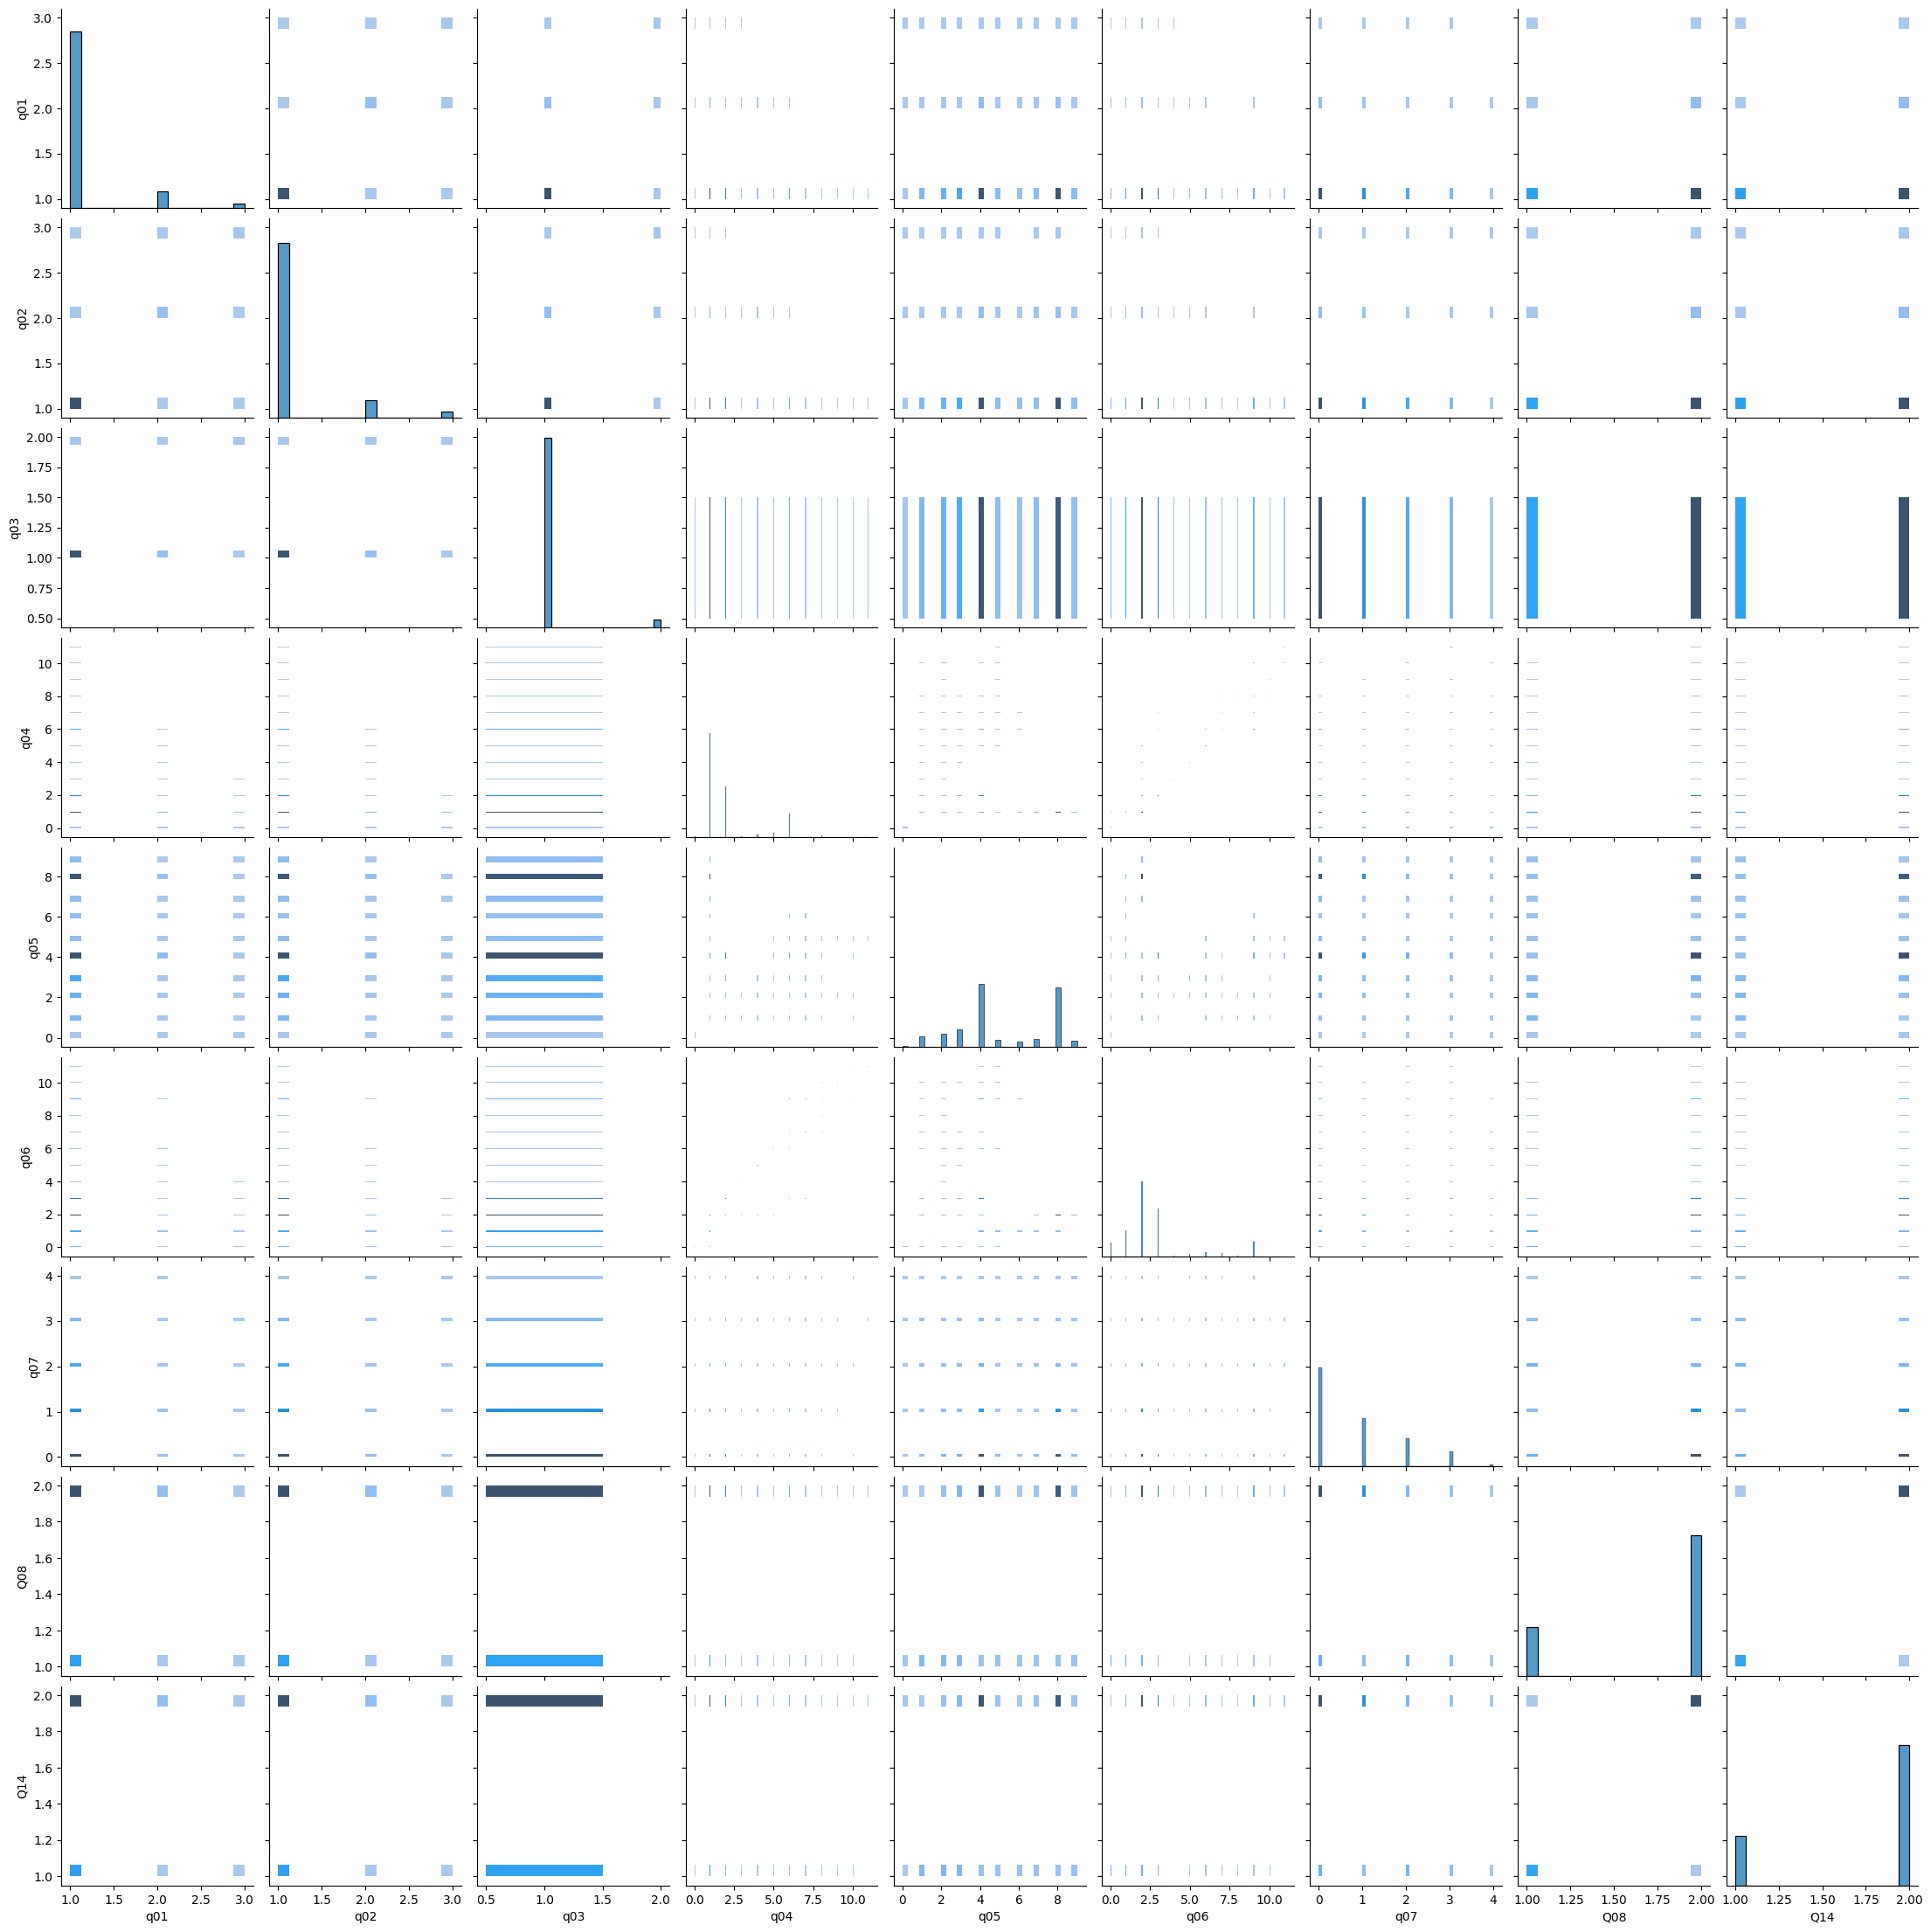

In [11]:
# they look pretty random to me, except for q4 and q6
# q4 and q6 are both related to education level, so it makes sense that they are correlated:
# q4) What is the highest grade [Name] have completed in school? In which level?
# q6) What is the highest diploma [Name] have attained?
threshold = 0.2
valid_columns = edu_train.isnull().sum(axis=0) / edu_train.shape[0] < threshold
valid_columns = valid_columns[valid_columns].index.tolist()

# they don't seem to have correlations, so I'm removing them from the plot for clarity
valid_columns.remove("psu")
valid_columns.remove("hh")
valid_columns.remove("idcode")

sns.pairplot(edu_train[valid_columns], kind="hist")
print(valid_columns)

In [ ]:
# q1-3 are somewhat related to each other (about their level of literacy)
# q1) Can [Name] read the newspaper?
# q2) Can [Name] write a one page personal letter?
# q3) Has [Name] ever attended school?

# also q3 can terminate the survey if the answer is no. We might consider removing it too.

# q4 indicates most attended ["8 OR 9  YEARS" SCHOOL] or [GYMNAZIUM(SECONDARY GENERAL)]
# q5 range differs as it depends on q4, might consider removing it

# q7) How many years of preschool did [Name] attend?
# appears like a 1/x distribution

# q8) Did [Name] enroll or has you plans to enroll in school this academic year?
# q14) Did [NAME] enroll in the past academic year?
# these two appears to be closely related, the ones that didn't enroll in the past year are likely to not enroll in the current year